# Contexto ✒️

Notebook voltado ao estudo da otimização dos modelos de machine learning. A otimização dos modelos é parte essencial de um projeto, pois visa atingir um ponto de eficiência no qual o modelo funciona, conseguindo obter as melhores métricas, sem produzir sobreajuste (overfitting), permitindo a sua generalização para o objetivo que fora construído.

O estudo se debruçará num case de uma locadora de veículos, que pretende desenvolver um modelo que preveja, com base nas features presentes, se um cliente tende a ser inadimplente ou adimplente.

Para tanto, desenvolverei modelos de machine learning otimizados que sejam capazes de prover uma classificação, prevista, dos clientes. Uma vez que o escopo do estudo passa pelo escopo da otimização, será apresentado e explicado as principais abordagens de otimização usadas, a saber :

- validção cruzada com GridSearchCV
- validação cruzada aninhada
- busca aleatória (RandomSearchCV)
- Otimização Baysiana

>

Dado que as validações cruzadas, tanto a aninhada quanto a não aninhada demandam elevados custos de processamento, exigindo um maior intervalo de tempo para a execução na célula do Google Colab, eu apenas construirei os pertinentes códigos e utilizarei os parâmetros encontrados pela busca aleatória, a qual também pode ser ou não aninhada. A possibilidade disso ocorre, pois apesar de aleatória os melhores hiperparâmetros em relação ao universo total das possibilidades possuem baixa dimensionalidade ( será explicado quando chegar na parte da otimização por busca aleatória ).

## Bibliotecas utilizadas 📚

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from numpy import linspace
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

In [58]:
!pip install scikit-optimize

## DataFrame 💾

In [2]:
file_path = '/content/dados_inadimplencia.csv'

df = pd.read_csv(file_path)


## Visualizando e identificando a qualidade dos dados 🔍

In [3]:
df.head()

,receita_cliente,anuidade_emprestimo,anos_casa_propria,telefone_trab,avaliacao_cidade,score_1,score_2,score_3,score_social,troca_telefone,inadimplente
0,16855.246324,2997.000000,12.157324,0,2.0,0.501213,0.003109,0.513171,0.117428,243.0,1
1,13500.000000,2776.050000,12.157324,0,2.0,0.501213,0.269730,0.513171,0.097900,617.0,0
2,11250.000000,2722.188351,12.157324,0,3.0,0.701396,0.518625,0.700184,0.118600,9.0,0
3,27000.000000,6750.000000,3.000000,0,2.0,0.501213,0.649571,0.513171,0.047400,300.0,0
4,22500.000000,3097.800000,12.157324,0,2.0,0.440744,0.509677,0.513171,0.014400,2913.0,1


In [4]:
df.isnull().sum()

receita_cliente        0
anuidade_emprestimo    0
anos_casa_propria      0
telefone_trab          0
avaliacao_cidade       0
score_1                0
score_2                0
score_3                0
score_social           0
troca_telefone         0
inadimplente           0
dtype: int64

In [5]:
df.duplicated().sum()

174

In [6]:
duplicados = df.duplicated().sum()

print(f' Proporção de dados duplicados no dataframe {(duplicados / df.shape[0]).round(3)}')

 Proporção de dados duplicados no dataframe 0.012


In [7]:
# Dado que a proporção de dados duplicados no dataframe
# é ínfimo, muito pequeno, para tratar os dados irei
# simplesmente excluí-los no conjunto de dados, para que
# não promovam nenhum efeito negativo na precisão dos modelos criados

df = df.drop_duplicates()

In [8]:
df.describe()

,receita_cliente,anuidade_emprestimo,anos_casa_propria,telefone_trab,avaliacao_cidade,score_1,score_2,score_3,score_social,troca_telefone,inadimplente
count,14404.000000,14404.000000,14404.000000,14404.000000,14404.000000,14404.000000,14404.000000,14404.000000,14404.000000,14404.000000,14404.000000
mean,17190.182904,2759.145838,12.365032,0.266870,2.047486,0.478186,0.489011,0.509489,0.116605,926.031181,0.318939
std,9416.466372,1265.068099,7.645418,0.442339,0.499308,0.143422,0.197211,0.067674,0.075063,797.210812,0.466082
min,2700.000000,332.100000,0.000000,0.000000,1.000000,0.017177,0.000005,0.000527,0.000000,0.000000,0.000000
25%,11700.000000,2036.475000,12.157324,0.000000,2.000000,0.467094,0.356839,0.513171,0.092800,276.000000,0.000000
50%,16855.246324,2722.188351,12.157324,0.000000,2.000000,0.501213,0.527309,0.513171,0.117428,742.500000,0.000000
75%,20250.000000,3152.250000,12.157324,1.000000,2.000000,0.501213,0.644599,0.513171,0.117428,1502.000000,1.000000
max,450000.000000,22500.000000,69.000000,1.000000,3.000000,0.931287,0.820487,0.866731,1.000000,4128.000000,1.000000


In [9]:
df.shape

(14404, 11)

## Analisando quais são as features mais significativas 🔍

A análise das variáveis mais significativas se dará mediante a três abordagens, por meio da matriz de correlação, por meio da seleção de um modelo de machine learning, será utilizado, para tanto, o random forest.

Essa análise é importante para sabermos quais são as features que melhor explicam a variável target, buscando com isso reduzir a colinearidade possívelmente presente, bem como dimensionalidade desnecessária, uma vez que o primeiro pode aumentar o ruído dos dados, dificultando na precisão do modelo, e o outro produzir elevados custos de processamento.

### Matriz de correlação 🧩

In [10]:
corr_matrix = df.corr()

<Axes: >

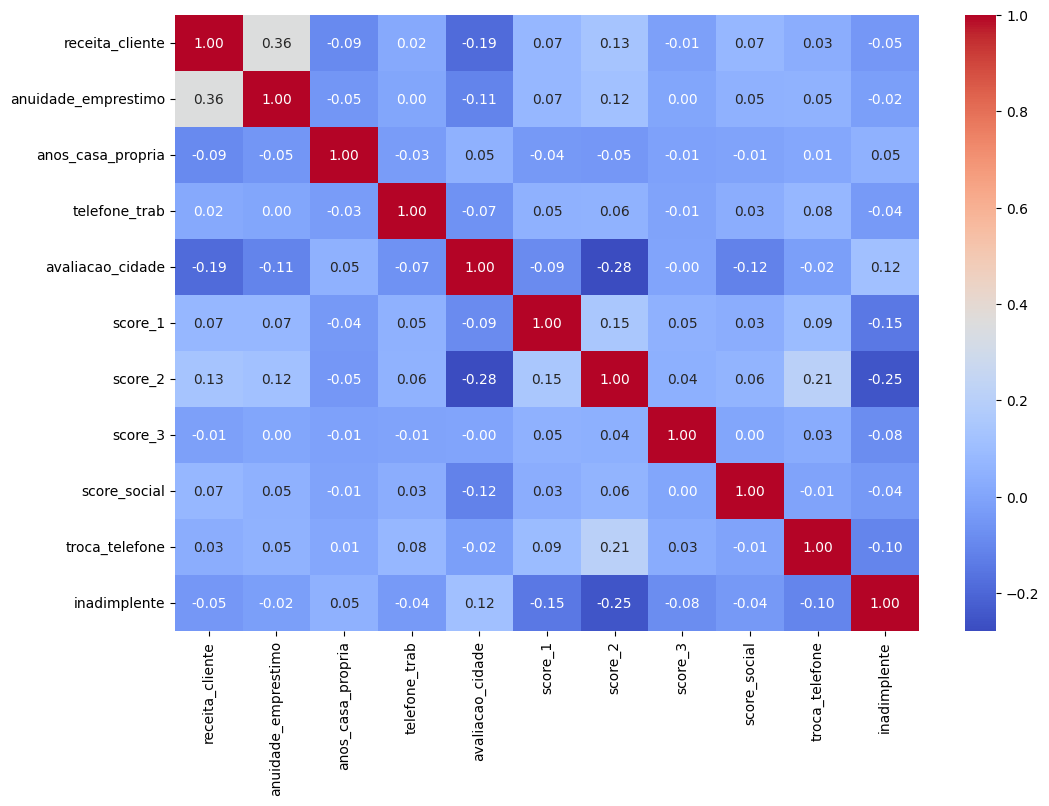

In [11]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')

Segundo a matriz de correlação, parece que as features mais significativas, com base em sua relação linear, são score_2, score_1, troca_telefone, score_3, receita_cliente e avaliacao_cidade.  Ambos os scores se relacionam com o coportamento financeiro do cliente, que pode informar a tendência que ele possui de se qualificar como inadimplente ou adimplente, de modo que clientes com melhores scores tencionam a ser clientes adimplentes.

Importante notar que com exceção da feature acerca da avaliação das cidades, todas as demais apresentam caráter negativo, o que significa que desempenham uma relação negativa com a variável target. Por exemplo, tomando como base a feature que se refere a troca de telefone dos clientes, pode-se inferir que quanto maior a troca menos adimplente o cliente tende a ser. A mesma inferência também se dá para as demais features negativas, enquanto que para a única positiva ocorre o oposto, uma vez que apresenta uma relação positiva, podendo indicar que quanto melhor avaliada é a cidade, mais os clientes que são cidadão dessas tendem a ser adimplentes.

### Importância das features segundo o random forest 🌳🌳🌳

In [12]:
# Analisando a proporção das categorias na variável target,
# de modo que 1 indica inadimplentes, enquanto que 0 adimplentes.

pd.DataFrame(df['inadimplente'].value_counts('normalize').round(3))

,proportion
inadimplente,
0,0.681
1,0.319


Uma vez que nota-se a presença de uma disproporcionalidade nos dados, recomenda-se que algumas abordagens sejam tomadas, como o balanceamento nos dados, perpassando, para tanto, as técnicas de oversampling ou undersampling, ou a estratificação dos dados, segundo a variável target, na etapa de separação nos dados de treinamento e teste. No presente notebook, a abordagem escolhida será a da estatificação, porém, caso fosse tomada a de balanceamento, podera ser utilizado a técnica de oversampling - SMOTE. Para saber sobre o que se trata, consultar : https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html

In [13]:
# Separando os dados em X e em y :

X = df.drop('inadimplente', axis=1)
y = df['inadimplente']

In [14]:
# Definindo a semente de aleatoriedade, para garantir reprodutibilidade :

SEED = 22

In [15]:
# Separando em treino e teste :

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=SEED, stratify=y)

In [16]:
# Instanciando o modelo :

rf_select_features = RandomForestClassifier(random_state=SEED, max_depth=10,
                                            n_estimators=250, max_features='sqrt',
                                            min_samples_leaf=10, min_samples_split=2,
                                            criterion='gini')

In [17]:
rf_select_features.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=10, n_estimators=250,
                       random_state=22)

In [18]:
# Verificando a importância por cada feature :

feature_importance = pd.DataFrame({'colunas' : X_train.columns, 'importancia' : rf_select_features.feature_importances_})

feature_importance.sort_values(by = 'importancia', ascending = False)

,colunas,importancia
6,score_2,0.379156
5,score_1,0.183398
9,troca_telefone,0.118429
1,anuidade_emprestimo,0.082066
0,receita_cliente,0.056217
8,score_social,0.054592
2,anos_casa_propria,0.048626
7,score_3,0.037104
4,avaliacao_cidade,0.031188
3,telefone_trab,0.009223


Analisando a tabela gerada pelo modelo de ML acerca das features mais importantes, verifica-se que as menos importantes são do score_3 em diante, sendo o telefone de trabalho a menos importantes, o que, de certo modo, diverge da matriz de correlação, a qual havia encontrado uma correlação negativa com a target.

## Selecionando as features mais importantes 🖍️

Com base na análise da matriz de correlação e do modelo de random forest, constata-se uma maior significância de certas features em comparação com outras. Ainda que no presente dataframe não exista à primeira vista uma elevada dimensionalidade, sendo de apenas 11 dimensões, faz-se necessário sempre utilizar o critério da parcimônio, buscando a eficiência.

Em particular, dados com elevada dimensão no contexto da otimização de modelos de machine learning também são onerosos no que tange ao tempo de processamento demandado durante a procura dos melhores hiperparâmetros, principalmente na utilização de algoritmos como o GridSearchCV, que itera sobre cada combinação, relativa a cada modelo criado, verificando a sua eficiência segundo uma métrica fornecida. O processo por si mesmo exige uma elevada capacidade de processamento, a qual, adicionada a uma alta dimensionalidade, pode exigir ainda mais, fazendo-se necessário, mais uma vez, a procura pela redução de dimensionalidade.

Existem duas principais abordagens para a redução de dimensionalidade, sendo a Análise de Componentes Principais (PCA), que realiza uma combinação entre dimensões relacionadas, buscando reduzir a dimensionalidade dos dados, enquanto descarta as que possuem menos relevância e a seleção de features, que com base na significância estatística seleciona-se, sem combinar, determinadas dimensões em detrimento de outras. A abordagem utilizada no presente notebook será a de seleção de features.

>

**Sobre PCA :**

https://medium.com/aimonks/principal-component-analysis-pca-in-machine-learning-407224cb4527


In [19]:
# Buscando reduzir a dimensionalidade dos dados,
# selecionarei as features que sejam mais significativas,
# segundo o modelo de ML utilizado :

df_seleccionado = df[['score_2', 'score_1', 'troca_telefone',
                      'anuidade_emprestimo', 'receita_cliente', 'score_social',
                      'anos_casa_propria', 'inadimplente']]




In [20]:
# Segmentando em X e em y :

X = df_seleccionado.drop('inadimplente', axis=1)
y = df_seleccionado['inadimplente']

In [21]:
# Verificando a proporcionalidade da variável target :

df_seleccionado['inadimplente'].value_counts('normalize').round(3)

inadimplente
0    0.681
1    0.319
Name: proportion, dtype: float64

In [22]:
# Separando os dados novamente em treino e teste :

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y,
                                                    random_state= SEED)

## Otimização do modelo  ✔️

Otimização de algo significa encontrar o seu ponto de ótimo, no qual esse desempenha com o máximo de eficiência. Em termos de ML, tal ponto de ótimo se relaciona com a capacidade do modelo aprender e de generalizar para novos dados que anteriormente não foram vistos por ele.

Partindo da premissa que aprender significa acertar, concebe-se que o aprendizado de um modelo está fortemente atrelado com a sua precisão (que no caso de um modelo de classifação seria de classificar as categorias a que pertence determinado conjunto de dados - cliente adimplente ou inadimplente, no presente contexto).

Da mesma forma, generalizar, aqui, significa conseguir acertar o que anteriormente não fora visto na etapa de treinamento, etapa na qual verifica-se de fato o aprendizado do modelo.

Ambos os processos, por outro lado, são atravessados por dois possíveis cenários : underfitting e overfitting. Tanto um quanto outro prejudica o aprendizado do modelo, verificado em sua capacidade de generalização, no qual se dá a sua validação. O primeiro se relaciona a um sub-treinamento, no qual o modelo treina pouco antes do processo de previsão para dados anteriormente não vistos, enquanto que o segundo se refere a um sobre-treinamento, no qual o modelo se ajusta muito aos dados, possuindo uma precisão elevado na parte de treinamento, porém baixa na de validação, justamente porque o sobre-ajuste diminui a sua capacidade de generalizar para dados não vistos.

Não obstante e com base nisso é que se dá o processo de otimização de um modelo de ML, de modo que busca-se equilibrar ambos cenários de treinamento, nos quais ele nem treina pouco e nem muito, buscando com isso que ele tenha a capacidade de generalizar para dados anteriormente não vistos, apresentando uma boa pontuação de acerto com eles.

Por fim, porém não menos importante, um modelo de ML é construído junto de hiperparâmetros que se relacionam à natureza do próprio modelo. Nesse sentido, são eles que são responsáveis de 'aprender' com os dados, produzindo uma determinada saída. Desse modo, na otimização também busca-se encontrar os melhores hiperparâmetros dos modelos de ML, os quais serão responsáveis por prover a esses o melhor aprendizado, aferido a partir da pontuação de determinadas métricas, que costumam ser : acurácia, precisão, recall, f1-score e matriz de confusão.

**Para saber mais sobre as métricas :**

https://vitorborbarodrigues.medium.com/métricas-de-avaliação-acurácia-precisão-recall-quais-as-diferenças-c8f05e0a513c




## Algoritmos de otimizaçao 🤖

Dentre os principais algoritmos de otimização, há o GridSearchCV, RandomSearch e otimização baysiana. Não obstante, tanto o primeiro algoritmo quanto o segundo algoritmo podem ser utilizados segundo uma validação cruzada aninhada ou não.

>

### GridSearchCV

Algoritmo que realia uma busca em grid dos melhores hiperparâmetros junto de uma validação cruzada, utilizada para reduzir o sobre-ajuste aos dados (reduzir overfitting). Nele, varíos modelos são combinados com cada parte dos dados que estão segmentados em 5 partes, sendo uma reservada para a validação, ainda na etapa de treinamento. A cada combinação, junto de cada modelo criado com bases em seus hiperparâmetros, o algoritmo avalia a sua eficiência, se é ou não é bom, com base em determinadas métricas informadas a ele, como o recall por exemplo, que mensura a taxa efetiva de acerto do modelo.

**Possível Ônus**

Um dos possíveis ônus em sua utilização é o custo de processamento, que justamente pela excessiva iteração, combinando os modelos em cada conjunto de dados e os avaliando, torna o processo de encontrar os melhores hiperparâmetros demorado por conta da quantidade de combinação possível gerada. Em virtude disso, a sua utilização é mais adequada a conjunto de dados pequenos e com pouca dimensionalidade.

>

### RandomSearchCV

Uma alternartiva ao GridSearchCV e que realiza o mesmo procedimento, com o diferencial de que ao invés de iterar sobre todo os dados do conjunto de dados realiza buscas aleatórias para tanto. Apesar de aleatório, tal abordagem encontra êxito justamente por conta da baixa dimensionalidade dos dados mais importantes ou significativos utilizados para encontrar os melhores hiperparâmetros. Nesse sentido, não são todos os dados que de forma homogênea apresentam a mesma relevância para a compreensão do melhor modelo, mas alguns.

Tal característica pode ser ilustrada por meio do seguinte exemplo : imagine que num conjunto de 100 dados, os dados realmente importantes são 7. Utilizando o GridSearchCV, a iteração se dará para cada dado, combinado-os com cada modelo criado - a partir dos hiperparâmetros anteriormente especificados -. Sem considerar os demais modelos, mas apenas 1, isso exigiria 100 combinações para verificar a pontuação do modelo informado.

Por outro lado, utilizando a busca aleatória, que procede de forma diferente, o que ocorreria ? Considerando que são 7 dados importantes, a chance de encontrarmos pelo menos um é de $(7 / 100)$. Considerando que podemos errá-los, tal chance de erro é de $( 1 - (7 / 100))$. Levando em conta que temos tal chance em um total de dados, para sabermos quantas vezes precisáriamos para encontrar os dados necessários : $(1 - (1 - (7 / 100))) ^x$, que daria 27 vezes.

Considerando que com o GridSearchCV precisamos executar 100 vezes cada combinação, o RandomSearchCV a encontra com 27 vezes, de forma aleatória. Tal diferença, portanto, demonstra a menor exigência de processamento demandado, que pode fazer significativa diferença para um projeto de ML, no qual é necessário encontrar os melhores hiperparâmetros de um modelo relacionado a um determinado conjunto de dados, em especial aqueles que possuem alta dimensionalidade.

**Possíveis vantagens**

Menor custo de processamento, sendo mais efetivo, em termos de intervalo de tempo necessário para a sua execução, que o GridSearchCV para datasets com alta dimensionalidade. Outra vantagem é que os hiperparâmetros por ele encontrado tendem a ser os mesmos daqueles que seriam encontrados pelo GridSearch, não havendo, portanto, uma significativa perda de um em relação ao outro, inclusive no que tange a precisão, sendo esse, se não equivalente, percentualmente baixo.

>

### Validação cruzada aninhada e não aninhada

A principal diferença de um e de outro se relaciona à adição mais uma camada de treino e validação, porém nas próprias camadas de treino, preservando ainda a camada única de validação. Isso significa que em cada camada que antes servia apenas para treino, agora irá possuir tanto um treinamento quanto teste, de modo a avaliar o desempenho do modelo, segundo uma determinada métrica informada. Só então, a partir desse processo interno de validação, em que o modelo é passado à etapa de validação, no qual obtém a sua pontuação final.

Essa abordagem é especialmente utilizada, pois por meio dela busca-se reduzir ainda mais o risco ao overfitting nos dados, visando reduzir o otimismo acerca da pontuação do modelo, frente ao o que na realidade é encontrado, devido a não mistura dos dados no processo de treino e validação, que ocorre, ainda que em menor grau, na validação cruzada. Desse modo, a sua utilização se relaciona a encontrar o melhor hiperparâmetro, com base em sua pontuação atrelado a uma determinada métrica, de modo que seja o menos otimista possível.

Acerca da validação não aninhada ocorre o oposto. Nela o conjunto de treino é dividida em treino, reservando uma para validação, por meio da qual o modelo será avaliado.

>

### Otimização Baysiana

A otimização bayesiana é uma técnica que utiliza informações prévias para gerar previsões posteriores, atualizando essas informações conforme a iteração especificada. Essa abordagem envolve três elementos principais: a função objetivo, o modelo substituto e a função de aquisição. Juntos, esses componentes ajudam a identificar o melhor conjunto de hiperparâmetros para um modelo de machine learning (ML).

- Função Objetivo

A função objetivo é responsável por encontrar os melhores hiperparâmetros que maximizem ou minimizem uma métrica de desempenho específica do modelo de ML, como precisão, recall ou outra métrica relevante. Inicialmente, a função objetivo treina o modelo com os hiperparâmetros fornecidos e depois os avalia com base na métrica especificada. A função objetivo é essencialmente a métrica que queremos otimizar, e suas avaliações são usadas para informar o processo de busca e seleção de hiperparâmetros. No gráfico abaixo, o melhor hiperparâmetro encontrado é demarcado pela estrela no topo da curva de distribuição.

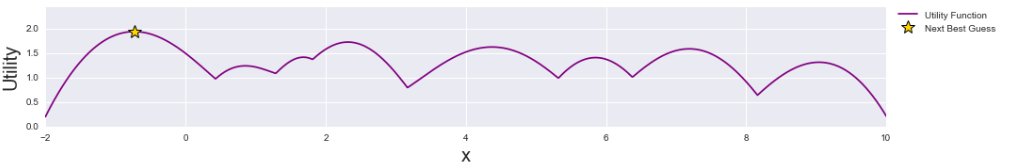

- Modelo Substituto

O modelo substituto é uma representação aproximada da função objetivo. Ele é mais barato e rápido de avaliar do que a função objetivo real. A Regressão Gaussiana (Gaussian Process) é comumente usada como modelo substituto devido à sua capacidade de fornecer tanto predições quanto incertezas dessas predições. À medida que novos pontos de dados são avaliados pela função objetivo, o modelo substituto é atualizado, melhorando sua precisão e capacidade de guiar a busca pelos melhores hiperparâmetros.

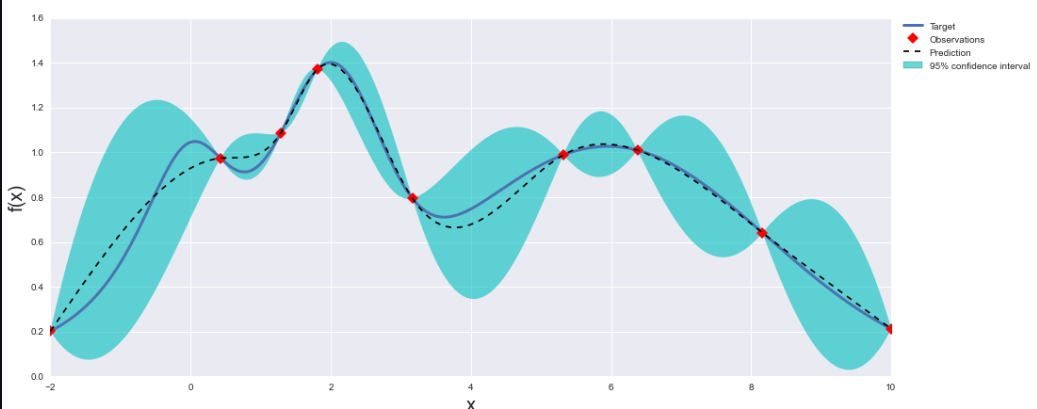

- Função de Aquisição

A função de aquisição é responsável por decidir quais hiperparâmetros testar a seguir. Ela equilibra a exploração de novas áreas do espaço de hiperparâmetros (onde a incerteza é alta) e a exploração de áreas conhecidas para melhorar as predições (onde já existem boas estimativas). Alguns exemplos comuns de funções de aquisição incluem Expected Improvement (EI), Upper Confidence Bound (UCB) e Probability of Improvement (PI).

**Exploração**

A exploração se concentra em áreas do espaço de busca que ainda apresentam alta incerteza. Essa estratégia ajuda a identificar possíveis regiões com bons hiperparâmetros que ainda não foram suficientemente exploradas.

**Exploração**

A exploração foca em áreas do espaço de busca onde as predições são mais confiáveis, utilizando as melhores informações já conhecidas para avaliar o desempenho dos hiperparâmetros encontrados.

- **Tratamento a overfitting**

O algoritmo de otimização bayesiano não apresenta um tratamento de validação cruzada explícito, semelhante aos algoritmos GridSearch e RandomSearch, podendo, no entanto, ser aplicado a ele a validação cruzada para que apresente tal característica. Por outro lado, há um certo tratamento implícito, que se dá por meio de uma regularização por adição de termos à matriz da covariância, o qual ajuda o sobreajuste aos dados. Além disso, a combinação de exploração com explotação auxilia nesse processo, uma vez que a exploração ajuda o modelo não se ajustar apenas segundo os hiperparâmetros que em um determinado momento apresentam a maior probabilidade de serem os melhores.


## Criando um modelo de baseline

A criação de modelos de baseline são úteis para a compreensão do desempenho dos modelos propriamente criados com o objetivo de serem efetivos na tarefa em que são propostos. Nesse sentido, se crio um modelo e o otimizo, porém seu desempenho é similar a um modelo Dummy (baseline por excelência) ou ao seu análogo padrão, significa que ele precisa ser reconsiderado ou que, no segundo caso, que a otimização não oferece grandes saltos em comparação com a implementação padrão.

Para o presente estudo, irei criar um DummyClassifier, bem como irei implementar o RandomForest, K-NN e modelo de regressão logística. No primeiro momento, irei treiná-los e mensurá-los com base em sua implementação padrão, sendo que posteriormente irei avaliá-los novamente, porém em sua forma otimizada. Importante dizer que não irei buscar a otimização de cada modelo por meio do GridSearch, devido ao custo de processamento, que ressoa no intervalo de tempo de espera para a conclusão da busca pelos melhores hiperparâmetros.

In [23]:
def avalia_modelos(nome_modelo, modelo):

  modelo.fit(X_train, y_train)
  y_predict = modelo.predict(X_test)

  acuracia = accuracy_score(y_test, y_predict)
  recall = recall_score(y_test, y_predict)
  precisao = precision_score(y_test, y_predict)
  f1 = f1_score(y_test, y_predict)

  print(f'\n {nome_modelo} \n')

  print(f'Acurácia: {(acuracia).round(3)}')
  print(f'Recall: {(recall).round(3)}')
  print(f'Precisão: {(precisao).round(3)}')
  print(f'F1-Score: {(f1).round(3)}')


In [ ]:
dummy_classifier = DummyClassifier(strategy='most_frequent', random_state = SEED)
random_forest = RandomForestClassifier(random_state = SEED)
knn = KNeighborsClassifier()
logistic_regression = LogisticRegression(random_state = SEED)

modelos = [('Dummy Classifier', dummy_classifier),
           ('Random Forest', random_forest),
           ('KN-Neighbors', knn),
            ('Logistic Regression', logistic_regression)]


In [ ]:
for nome_modelo, modelo in modelos:
  avalia_modelos(nome_modelo, modelo)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Dummy Classifier 

Acurácia: 0.681
Recall: 0.0
Precisão: 0.0
F1-Score: 0.0

 Random Forest 

Acurácia: 0.701
Recall: 0.28
Precisão: 0.564
F1-Score: 0.374

 KN-Neighbors 

Acurácia: 0.605
Recall: 0.205
Precisão: 0.317
F1-Score: 0.249

 Logistic Regression 

Acurácia: 0.681
Recall: 0.001
Precisão: 0.5
F1-Score: 0.002


Por padrão, nota-se que os modelos de ML não apresentam uma acurácia significativamente superior ao modelo Dummy, sendo no caso o KN-Neighbors até inferior. Não obstante, as demais métricas não se mostram favoráveis, tendo em vista que os modelos apresentam uma taxa de acerto efetiva (reacall) baixa, influenciando no f1-score.

## Aplicando a otimização nos modelos

In [24]:
# Define-se a validação cruzada :

# Validação cruzada com 5 divisões, sendo uma para
# validação e as demais para treino, com mistura,
# de modo a impedir que os dados estejam ordenados,
# através do shuffle = True.

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state = SEED)



## Otimizando o Random Forest com CV 🌳🌳🌳

In [ ]:
# Definindo o universo de hiperparâmetros
# a serem testados para o modelo random forest.

# n_estimators -> quantidade de árvores
# criterion -> critério de separação dos dados presentes nas folhas
# max_depth -> profundidade máxima da árvore
# min_samples_leaf -> qt. mínima de amostras por folha
# min_samples_split -> qt. mínima de amostras por divisão
# max_features -> qt. máximas de features avaliadas em cada processo, folha.

param_grid_rf = {
    'n_estimators': [200, 250, 300],
    'criterion':  ['gini', 'entropy'],
    'max_depth': [2, 8, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [5, 10, 20],
    'max_features': ['sqrt', 'log2']
   }

In [ ]:
# O hiperparâmetro scoring se relaciona a que métrica utilizamos
# para encontrar os melhores hiperparâmetros e, portanto, o modelo
# otimizado. Ao utilizar, por exemplo, o recall, estou informando
# que quero encontrar o modelo otimizado por meio de seu acerto efetivo.

rf_grid = GridSearchCV(estimator = RandomForestClassifier(random_state= SEED),
             param_grid = param_grid_rf,
             scoring = "recall", # Métrica de avaliação
             n_jobs = -1, # Informa que desejo utilizar 2 núcleos de processamento.
             cv = cv)

In [ ]:
%%time

# Treinando os modelos criados pelo Grid e StratifiedKFold :

rf_grid.fit(X_train, y_train)

In [ ]:
# Ao treinar o modelo, pode-se verificar
# os melhores hiperparâmetros da seguinte forma :

rf_grid.best_params_

In [ ]:
# Por motivos de tempo de processamento, não executei
# a célula, mas os melhores hiperparâmetros encontrados
# seria :

n_estimators = 200
max_depth = 10
criterion = 'gini'
min_samples_split = 2
min_samples_leaf = 10
max_features = 'sqrt'

# Instanciando o modelo :

opt_rf_CV = RandomForestClassifier(n_estimators = n_estimators,
                                max_depth = max_depth,
                                criterion = criterion,
                                min_samples_split = min_samples_split,
                                min_samples_leaf = min_samples_leaf,
                                random_state = SEED)

## Otimizando o modelo de Regressão Logística com CV

In [85]:
# max_iter -> qt. máxima de iterações
# solver -> métrica que conduz a otimização
# penalty -> tipo de regularização (l1, l2, elasticnet - a combinação dos dois anteriores)
# C -> refere-se à força da regularização, de modo que para valores
#      elevados a regularização é mais forte, podendo gerar overfitting.

max_iter = np.linspace(100, 300, 5, dtype=int)
c = [0.001, 0.01, 0.1, 1, 10]

param_grid_lr = [
    {'logisticregression__solver' : ['newton-cg', 'lbfgs'],
      'logisticregression__penalty' : ['l1','l2','elasticnet'],
      'logisticregression__max_iter' : max_iter,
       'logisticregression__C' : c}
]

In [ ]:
lr_grid_search = GridSearchCV(estimator = make_pipeline(StandardScaler(), LogisticRegression(random_state = SEED)),
                               param_grid = param_grid_lr,
                               scoring = "recall",
                               n_jobs = -1,
                               cv = cv)


In [ ]:
%%time

lr_grid_search.fit(X_train, y_train)

In [ ]:
# Para encontrar os melhores hiperparâmetros

lr_grid_search.best_params_

In [93]:
# Por motivos de tempo de processamento, não executei
# a célula de treinamento que iniciaria a busca pelos
# hiperparâmetros, mas os possíveis hiperparâmetros encontrados
# seriam :

opt_log_regression_CV = LogisticRegression(solver= 'newton-cg', penalty='l2', max_iter=300, C=10,
                                 random_state=SEED)

## Otimizando o KN-Neighbors com CV

In [ ]:
# Definindo a grade de hiperparâmetros
param_grid_knn = {
    'knn__n_neighbors': linspace(5, 25, 10, dtype=int),
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])


In [ ]:
knn_grid_search = GridSearchCV(estimator = pipe_knn,
                               param_grid = param_grid_knn,
                               scoring = "recall",
                               n_jobs = -1,
                               cv = cv)

In [ ]:
%%time

knn_grid_search.fit(X_train, y_train)

In [ ]:
# Para encontrar os melhores hiperparâmetros :

knn_grid_search.best_params_

In [ ]:
opt_knn_CV = KNeighborsClassifier(metric='manhattan', n_neighbors=5, weights='distance')

## Avaliando os modelos otimizados com a validação cruzada

Etapa destinada a avaliar o desempenho dos modelos otimizados, como forma de verificar se apresentam algum ganho em relação ao desempenho encontrado pela implementação padrão dos mesmos.

In [ ]:
modelos_otimizados_CV = [('Random Forest', opt_rf_CV),
                         ('Regressão Logística', opt_log_regression_CV),
                         ('KN-Neighbors', opt_knn_CV)]

for nome_modelo, modelo in modelos_otimizados_CV:
  avalia_modelos(nome_modelo, modelo)


 Random Forest 

Acurácia: 0.701
Recall: 0.201
Precisão: 0.591
F1-Score: 0.3


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)



 Regressão Logística 

Acurácia: 0.68
Recall: 0.006
Precisão: 0.368
F1-Score: 0.012

 KN-Neighbors 

Acurácia: 0.595
Recall: 0.263
Precisão: 0.331
F1-Score: 0.293


Analisando a métrica gerada pelos modelos otimizados por meio da validação cruzada, quando comparando com as métricas geradas pelos modelos em sua implementação padrão, nota-se que cada qual desempenhou de forma diferente. No caso do Random Forest, o recall diminuiu e aumentou-se a precisão, enquanto que na regressão logística melhorou-se o seu recall e média harmônica. Por fim, no modelo KN-Neighbors a acurácia foi um pouco perdida, aumentando, porém, o recall e média harmônica do modelo.

## Otimização com validação cruzada aninhada

In [28]:
# Para realizar a validação cruzada aninhada, temos que criar
# uma validação cruzada interna e externa. Além disso, a diferença
# da validação convencional é que na camada externa, obtém-se
# apenas o retorno da pontuação do melhor modelo gerado, de modo
# que para ver os melhores hiperparâmetros, deve-se chamar
# a porção interna.

# Porção interna :

inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state = SEED)

# Porção externa :

outer_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state = SEED)

In [ ]:
rf_nested_CV = GridSearchCV(estimator = RandomForestClassifier(random_state= SEED),
             param_grid = param_grid_rf,
             scoring = "recall",
             n_jobs = -1,
             cv = inner_cv)

In [ ]:
%%time

rf_nested_score = cross_val_score(rf_nested_CV, X_train, y_train, cv = outer_cv)

In [ ]:
# Para analisar a pontuação média do melhor hiperparâmetro :

print(f'Pontuação média do modelo encontrado e seu desvio padrão : {(rf_nested_score.mean()).round(3)} , {(rf_nested_score.std).std()}')

In [ ]:
# Para verificar os melhores hiperparâmetros encontrados :

rf_nested_CV.best_params_

O mesmo processo se repete, de modo similar à validação cruzada para cada modelo, bastando informar o campo de busca dos hiperparâmetros de cada qual, bem como criando a validação cruzada aninhada para eles. Devido a alta similaridade, não será demonstrado as implementações para os outros modelos.

## Otimizando com Busca Aleatória

### Random Forest 🌳🌳🌳

In [69]:
# Implementando a busca aleatória :

random_forest_rs = RandomizedSearchCV(estimator=RandomForestClassifier(random_state = SEED ),
            param_distributions=param_grid_rf,
            n_iter=100, # Determina o número, quantidade de iterações aleatórias
            scoring='recall',
            n_jobs=-1,
            cv = cv,
            random_state = SEED )



In [70]:
%%time

random_forest_rs.fit(X_train, y_train)

CPU times: user 11.1 s, sys: 1.7 s, total: 12.8 s
Wall time: 17min 24s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=22, shuffle=True),
                   estimator=RandomForestClassifier(random_state=22),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 8, 10],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [5, 10, 20],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 250, 300]},
                   random_state=22, scoring='recall')

In [71]:
# Encontrando os melhores hiperparâmetros :

random_forest_rs.best_params_


{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'max_depth': 10,
 'criterion': 'gini'}

In [73]:
# Criando o Random Forest otimizado com o random search :

opt_random_forest_rs = RandomForestClassifier(criterion='gini', max_depth=10,
                                         max_features='sqrt',
                                         min_samples_leaf=5,
                                         min_samples_split=10,
                                         n_estimators=200,
                                         random_state = SEED)

### KN-Neigbors

In [81]:
# Implementando a busca aleatória
knn_rs = RandomizedSearchCV(
    estimator = pipe_knn,
    param_distributions=param_grid_knn,
    n_iter=100,
    scoring='recall',
    n_jobs=-1,
    cv=cv,
    random_state=SEED
)

In [82]:
%%time

knn_rs.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 40 is smaller than n_iter=100. Running 40 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


CPU times: user 1.15 s, sys: 236 ms, total: 1.39 s
Wall time: 1min 1s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=22, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('knn', KNeighborsClassifier())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'knn__metric': ['euclidean',
                                                        'manhattan'],
                                        'knn__n_neighbors': array([ 5,  7,  9, 11, 13, 16, 18, 20, 22, 25]),
                                        'knn__weights': ['uniform',
                                                         'distance']},
                   random_state=22, scoring='recall')

In [83]:
knn_rs.best_params_

{'knn__weights': 'distance', 'knn__n_neighbors': 5, 'knn__metric': 'manhattan'}

In [84]:
# Criando o KNN otimizado com o random search :

opt_knn_rs = KNeighborsClassifier(metric='manhattan',
                                  n_neighbors=5, weights='distance')

### Otimizando o modelo de Regressão Logística

In [87]:
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('logisticregression', LogisticRegression(random_state = SEED))
])

# Implementando a busca aleatória
log_reg_rs = RandomizedSearchCV(
    estimator = pipe_lr,
    param_distributions=param_grid_lr,
    n_iter=100,
    scoring='recall',
    n_jobs=-1,
    cv=cv,
    random_state=SEED
)

In [88]:
%%time

log_reg_rs.fit(X_train, y_train)

CPU times: user 773 ms, sys: 124 ms, total: 897 ms
Wall time: 11.4 s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
345 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
85 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=22, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('logisticregression',
                                              LogisticRegression(random_state=22))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions=[{'logisticregression__C': [0.001, 0.01,
                                                                   0.1, 1, 10],
                                         'logisticregression__max_iter': array([100, 150, 200, 250, 300]),
                                         'logisticregression__penalty': ['l1',
                                                                         'l2',
                                                                         'elasticnet'],
                                         'logisticregression__solver': ['newton-cg',
                                                                        'lbfgs']}],
                   random_state=22, scoring='recall')

In [89]:
log_reg_rs.best_params_

{'logisticregression__solver': 'newton-cg',
 'logisticregression__penalty': 'l2',
 'logisticregression__max_iter': 300,
 'logisticregression__C': 10}

In [91]:
# Criando o modelo de regressão logística otimizado com o random search:

opt_log_reg_rs = LogisticRegression(solver= 'newton-cg', penalty='l2', max_iter=300, C=10,
                                 random_state=SEED)

In [92]:
# Criando a lista dos modelos otimizados com Random Search :

modelos_otimizados_RS = [
    ( 'Random Forest', opt_random_forest_rs),
    ( 'KN-Neighbors', opt_knn_rs),
    ( 'Regressão Logística', opt_log_reg_rs)
]

for nome_modelo, modelo in modelos_otimizados_RS:
  avalia_modelos(nome_modelo, modelo)


 Random Forest 

Acurácia: 0.703
Recall: 0.202
Precisão: 0.601
F1-Score: 0.302

 KN-Neighbors 

Acurácia: 0.595
Recall: 0.263
Precisão: 0.331
F1-Score: 0.293


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)



 Regressão Logística 

Acurácia: 0.703
Recall: 0.227
Precisão: 0.592
F1-Score: 0.328


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:425: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


Analisando os novos valores para as métricas dos modelos de machine learning, nota-se que as métricas encontradas pelos modelos otimizados com o random search são similares à otimização feita pelo grid search, sendo isso o esperado, tendo em vista que são esses hiperparâmetros que conseguem prover um ponto de ótimo ao modelo, o qual na validação cruzada feita pelo grid já havia sido verificado.

A grande diferença do random search como esperado é que ele reduz substancialmente o intervalo de tempo para a busca dos melhores hiperparâmetros durante o processo de otimização feita pelos algoritmos.

## Otimização Bayesiana

### Otimizando o Random Forest

In [45]:
space_rf = {
    'criterion': Categorical(['gini', 'entropy']),
    'max_depth': Integer(2, 10),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(2, 20),
    'max_features' : Categorical( ['sqrt', 'log2']),
    'n_estimators': Integer(150, 300)
}


In [29]:
rf_opt_bayesian = BayesSearchCV(
    estimator = RandomForestClassifier(random_state = SEED),
    search_spaces = space_rf,
    n_iter = 50,
    scoring = 'recall',
    n_jobs = -1,
    cv = inner_cv)

In [30]:
%%time

rf_opt_bayesian.fit(X_train, y_train)

CPU times: user 1min 9s, sys: 47.8 s, total: 1min 57s
Wall time: 9min 16s


BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=22, shuffle=True),
              estimator=RandomForestClassifier(random_state=22), n_jobs=-1,
              scoring='recall',
              search_spaces={'criterion': Categorical(categories=('gini', 'entropy'), prior=None),
                             'max_depth': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'max_features': Categorical(categories=('sqrt', 'log2'), prior=None),
                             'min_samples_leaf': Integer(low=2, high=20, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=20, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=150, high=300, prior='uniform', transform='normalize')})

In [31]:
rf_opt_bayesian.best_params_

OrderedDict([('criterion', 'gini'),
             ('max_depth', 10),
             ('max_features', 'sqrt'),
             ('min_samples_leaf', 7),
             ('min_samples_split', 20),
             ('n_estimators', 184)])

In [54]:
# Implementando o modelo otimizado :

opt_rf_bayesian = RandomForestClassifier(criterion='gini', max_depth=10,
                                         max_features='sqrt',
                                         min_samples_leaf=7,
                                         min_samples_split=20,
                                         n_estimators=184,
                                         random_state = SEED)

### Otimizando o KN-Neighbors

In [32]:
space_knn = {
    'n_neighbors': Integer(5, 25),
    'weights': Categorical(['uniform', 'distance']),
    'metric': Categorical(['euclidean', 'manhattan'])
}

In [33]:
knn_opt_bayesian = BayesSearchCV(
    estimator = KNeighborsClassifier(),
    search_spaces = space_knn,
    n_iter = 50,
    scoring = 'recall',
    n_jobs = -1,
    cv = inner_cv)

In [35]:
%%time

knn_opt_bayesian.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['manhattan', 5, 'distance'] before, using random point ['euclidean', 25, 'uniform']
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['manhattan', 5, 'distance'] before, using random point ['manhattan', 22, 'distance']
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['manhattan', 5, 'distance'] before, using random point ['manhattan', 10, 'uniform']
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point ['manhattan', 5, 'distance'] before, using random point ['manhattan', 11, 'uniform']
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: U

CPU times: user 1min 4s, sys: 42.9 s, total: 1min 47s
Wall time: 2min 8s


BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=22, shuffle=True),
              estimator=KNeighborsClassifier(), n_jobs=-1, scoring='recall',
              search_spaces={'metric': Categorical(categories=('euclidean', 'manhattan'), prior=None),
                             'n_neighbors': Integer(low=5, high=25, prior='uniform', transform='normalize'),
                             'weights': Categorical(categories=('uniform', 'distance'), prior=None)})

In [39]:
knn_opt_bayesian.best_params_

OrderedDict([('metric', 'manhattan'),
             ('n_neighbors', 5),
             ('weights', 'distance')])

In [55]:
# Implementando o modelo otimizado :

opt_knn_bayesian = KNeighborsClassifier(metric='manhattan', n_neighbors=5, weights='distance')

### Otimizando o modelo de regressão logística

In [48]:

space_lr = {
    'solver': Categorical(['newton-cg', 'lbfgs']),
    'penalty': Categorical( ['l2']),
    'max_iter': Integer(100, 300),
    'C': Real(0.001, 10, prior='log-uniform'),
}


In [49]:
lr_opt_bayesian = BayesSearchCV(
    estimator = LogisticRegression(random_state = SEED),
    search_spaces = space_lr,
    n_iter = 50,
    scoring = 'recall',
    n_jobs = -1,
    cv = inner_cv)

In [50]:
%%time

lr_opt_bayesian.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


CPU times: user 1min, sys: 45.1 s, total: 1min 46s
Wall time: 2min 16s


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:425: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=22, shuffle=True),
              estimator=LogisticRegression(random_state=22), n_jobs=-1,
              scoring='recall',
              search_spaces={'C': Real(low=0.001, high=10, prior='log-uniform', transform='normalize'),
                             'max_iter': Integer(low=100, high=300, prior='uniform', transform='normalize'),
                             'penalty': Categorical(categories=('l2',), prior=None),
                             'solver': Categorical(categories=('newton-cg', 'lbfgs'), prior=None)})

In [53]:
lr_opt_bayesian.best_params_

OrderedDict([('C', 10.0),
             ('max_iter', 300),
             ('penalty', 'l2'),
             ('solver', 'newton-cg')])

In [56]:
# Implementando o modelo otimizado :

opt_lr_bayesian = LogisticRegression(solver= 'newton-cg', penalty='l2', max_iter=300, C=10,
                                 random_state=SEED)

## Em síntese...

Em síntese, verifica-se que ambos os modelos de busca de hiperparâmetros produzem resultados similares no que se refere a criação de modelos que apresentam boas pontuações segundo as métricas analisadas, como acurácia, recall, precisão e f1-score, divergindo de cada qual, principalmente, no custo de processamento, que se traduz no intervalo de espera, para a execução de cada busca, de modo que o Grid Search se notabiliza por ser o algoritmo que apresenta o maior tempo de espera para a sua execução.

Não obstante, observa-se que não há mudança significativa nos hiperparâmetros encontrados para cada algoritmo de busca, com exeção de alguns casos, como no Random Forest, o qual apresentou mudança significativa dos melhores hiperparâmetros encontrados, divergindo daqueles observados pelo Grid Search e Random Search para o mesmo modelo. Apesar da diferença vista, essa não produziu resultados dissonantes quanto as pontuações de cada métrica analisada.

Por fim, concebe-se que, considerando o custo de processamento e resultados semelhantes para cada algoritmo de otimização, que a utilização do Grid Search não é efetiva para datasets que apresentam significativa dimensionalidade, sendo mais recomendado o uso do Random Search e/ ou da otimização Bayesiana, que diferente de outros modelos realiza uma busca mais efetiva, uma vez que considera a busca anterior para realizar a posterior, combinando a sua procura em exploração e explotação, para encontrar os melhores hiperparâmetros.